# PSIR Reconstruction - Adapted from Olivier Mougin's Code

Based on Mougin et al. (2016) MRM 76:1512-1516

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
def show_slices(slices, clims=[0.0, 0.0]):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(5*len(slices), 5))
    if len(slices) == 1:
        axes = [axes]
    for i, slice in enumerate(slices):
        if clims == [0.0, 0.0]:
            axes[i].imshow(slice.T, cmap='gray', origin="lower")
        else:
            axes[i].imshow(slice.T, cmap='gray', origin="lower", clim=clims)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def maxk(A, k):
    """ Get k largest values from array """
    B = np.sort(np.ndarray.flatten(A))
    t = B.size
    y = B[t-k:]
    return y

## 1. Load Data and Check Voxel Size

In [4]:
# Input files - adjust the base path for your system
base_path = "/home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix"
prefix = "PARREC_WIPPSIR1mm3SENSE_20141016132749_15"

# Load magnitude images
imgm1 = nib.load(f"{base_path}/{prefix}_t787.nii.gz")
imgm2 = nib.load(f"{base_path}/{prefix}_t2387.nii.gz")

# Load phase images
imgp1 = nib.load(f"{base_path}/{prefix}_ph_t787.nii.gz")
imgp2 = nib.load(f"{base_path}/{prefix}_ph_t2387.nii.gz")

# Get data
imgm1_data = np.squeeze(imgm1.get_fdata())
imgm2_data = np.squeeze(imgm2.get_fdata())
imgp1_data = np.squeeze(imgp1.get_fdata())
imgp2_data = np.squeeze(imgp2.get_fdata())

# Check voxel size
voxel_size = imgm1.header.get_zooms()
print(f"Data shape: {imgm1_data.shape}")
print(f"Voxel size: {voxel_size}")
print(f"TI1 magnitude range: [{imgm1_data.min():.0f}, {imgm1_data.max():.0f}]")
print(f"TI2 magnitude range: [{imgm2_data.min():.0f}, {imgm2_data.max():.0f}]")
print(f"Phase range: [{imgp1_data.min():.3f}, {imgp1_data.max():.3f}] rad")

# Middle slices for visualization
midslice = imgm1_data.shape[2] // 2
midy = imgm1_data.shape[1] // 2
midx = imgm1_data.shape[0] // 2

output_dir = base_path

Data shape: (224, 224, 120)
Voxel size: (np.float32(0.893), np.float32(0.893), np.float32(1.0))
TI1 magnitude range: [0, 2469299]
TI2 magnitude range: [0, 2487738]
Phase range: [-3.142, 3.140] rad


## 2. Visualize Input Data

Input magnitude images:


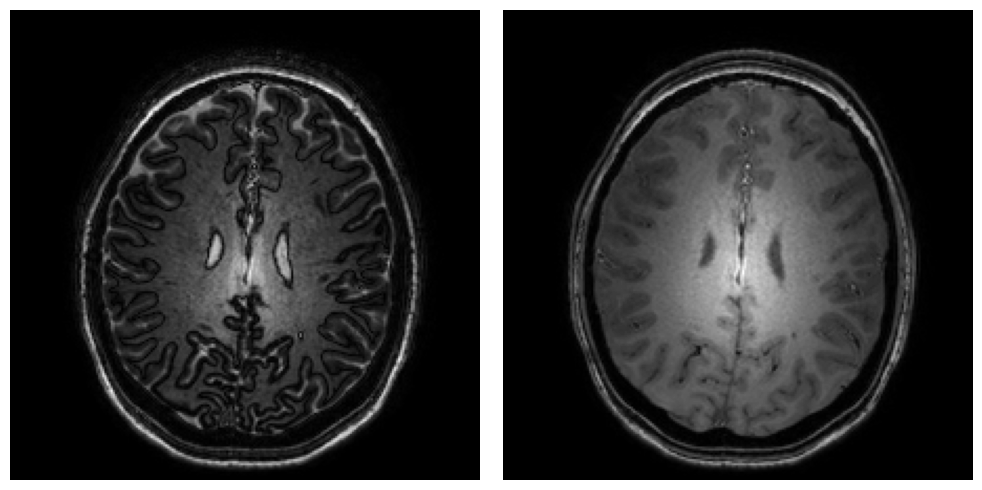

Input phase images:


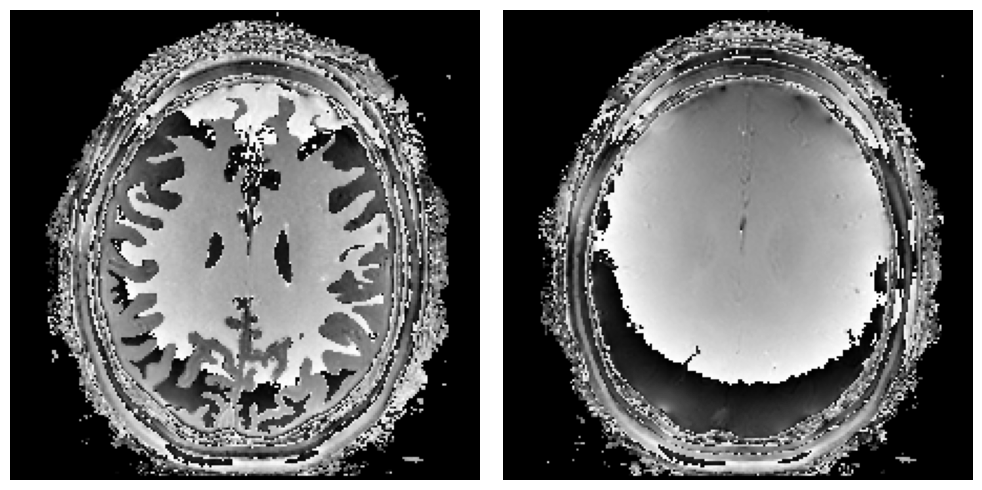

In [5]:
print("Input magnitude images:")
show_slices([imgm1_data[:, :, midslice], imgm2_data[:, :, midslice]])

print("Input phase images:")
show_slices([imgp1_data[:, :, midslice], imgp2_data[:, :, midslice]])

## 3. Create Complex Images

Combine magnitude and phase to create complex signals S1 and S2

Complex images created
S1 real range: [-1909949, 1168457]
S1 imag range: [-1611229, 2423320]
S1 - Real and Imaginary parts:


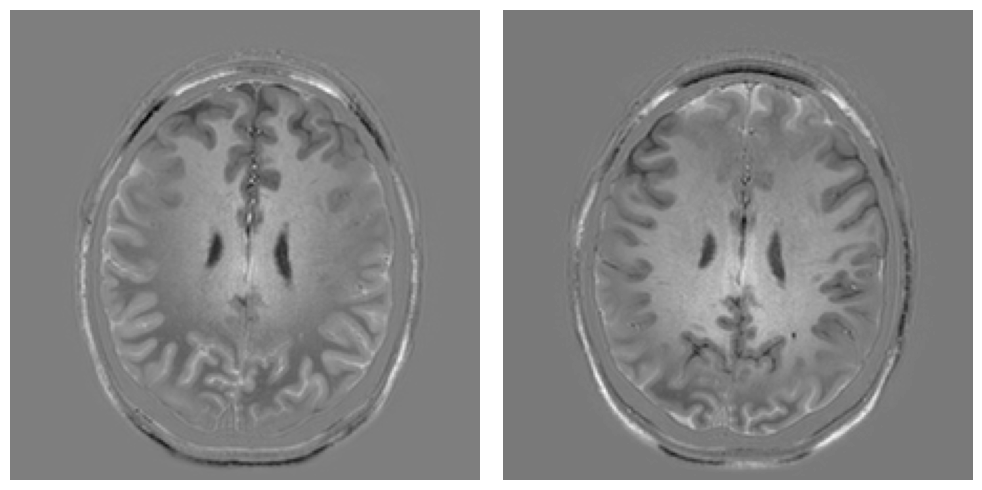

In [6]:
# Create complex images: S = magnitude × exp(i×phase)
S1 = np.multiply(imgm1_data, np.exp(1j * imgp1_data))
S2 = np.multiply(imgm2_data, np.exp(1j * imgp2_data))

print("Complex images created")
print(f"S1 real range: [{np.real(S1).min():.0f}, {np.real(S1).max():.0f}]")
print(f"S1 imag range: [{np.imag(S1).min():.0f}, {np.imag(S1).max():.0f}]")

# Visualize real and imaginary parts
print("S1 - Real and Imaginary parts:")
show_slices([np.real(S1[:, :, midslice]), np.imag(S1[:, :, midslice])])

## 4. Polarity Restoration Using Phase

Use complex conjugate multiplication to determine polarity:
- T1w = Re(S1* × S2)
- Sign of T1w tells us the polarity

Polarity-corrected S1m range: [-626928, 2469299]
Normalization S0 range: [0, 4957037]
Polarity map (sign of T1w):


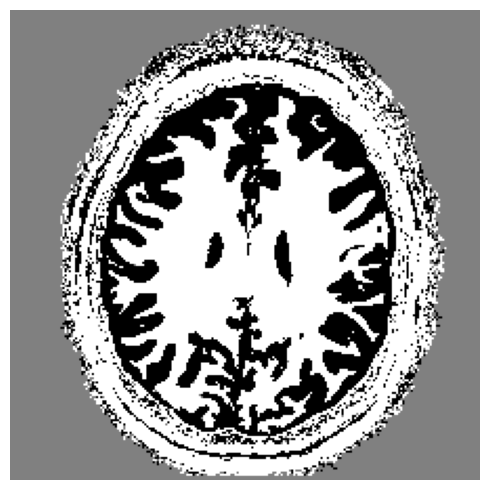

Polarity-corrected S1m (3 orthogonal slices):


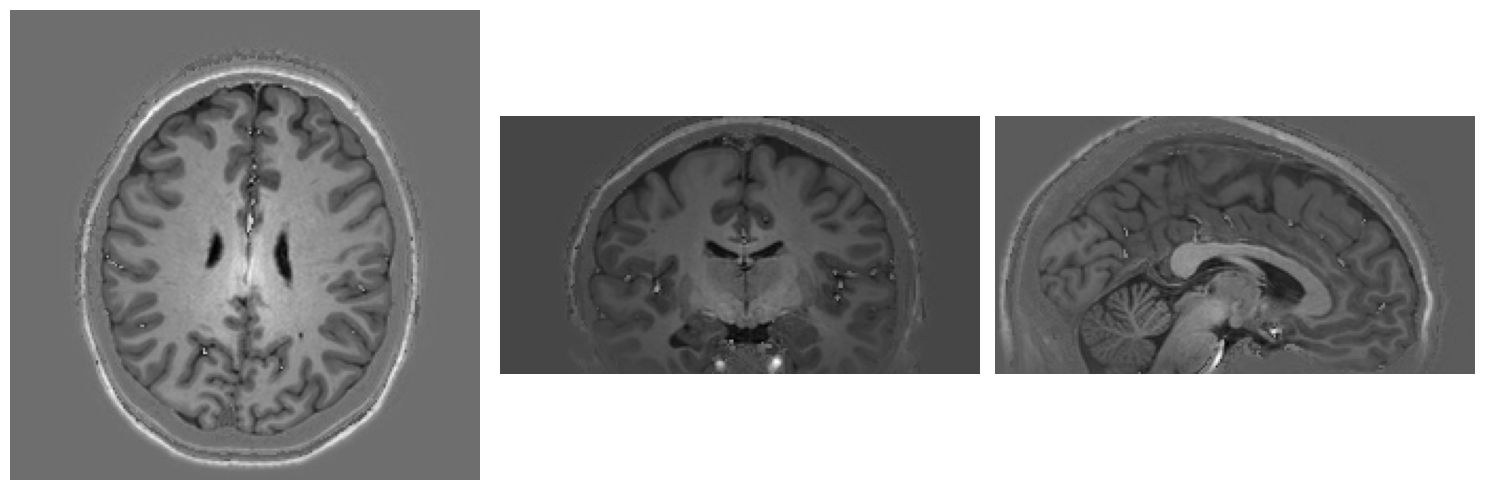

Normalization image S0 (3 orthogonal slices):


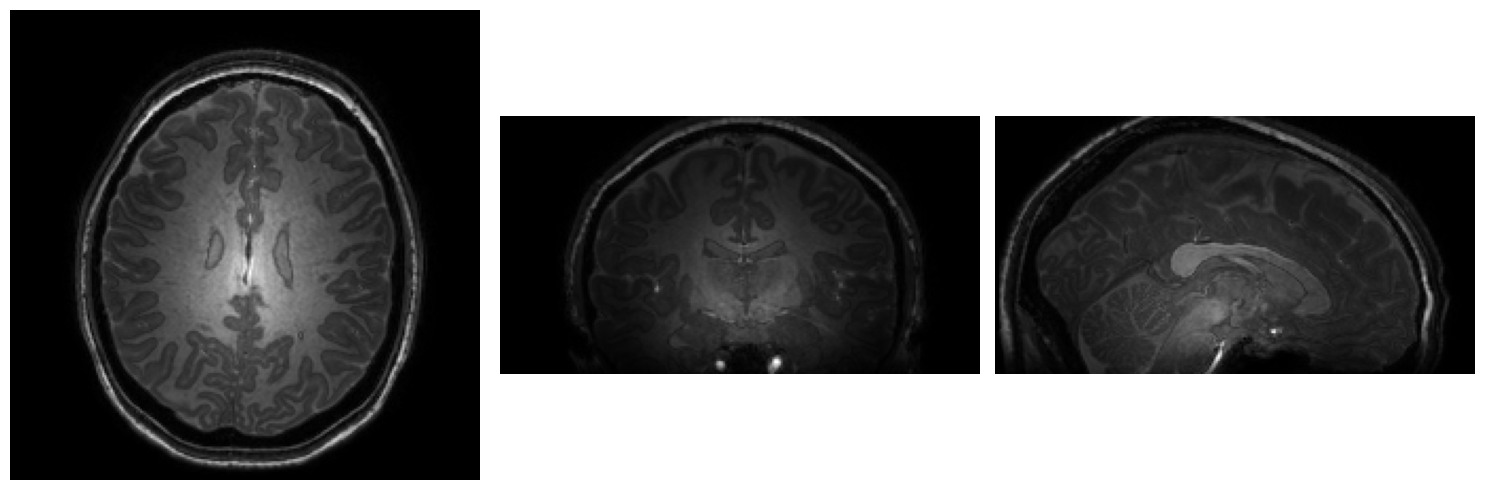

In [7]:
# Compute polarity from phase using Mougin's method
T1w = np.real(np.multiply(np.conj(S1), S2))
f = np.sign(T1w)  # Polarity map: +1 or -1

# Apply polarity to magnitude of S1
S1m = np.multiply(np.abs(S1), f)

# Normalization image (sum of magnitudes)
S0 = np.abs(S1m) + np.abs(S2)

print(f"Polarity-corrected S1m range: [{S1m.min():.0f}, {S1m.max():.0f}]")
print(f"Normalization S0 range: [{S0.min():.0f}, {S0.max():.0f}]")

# Visualize
print("Polarity map (sign of T1w):")
show_slices([f[:, :, midslice]], [-1, 1])

print("Polarity-corrected S1m (3 orthogonal slices):")
show_slices([S1m[:, :, midslice], S1m[:, midy, :], S1m[midx, :, :]])

print("Normalization image S0 (3 orthogonal slices):")
show_slices([S0[:, :, midslice], S0[:, midy, :], S0[midx, :, :]])

## 5. Compute MP2RAGE

$$\text{MP2RAGE} = \frac{\text{Re}(S1^* \times S2)}{|S1|^2 + |S2|^2}$$

MP2RAGE range: [-0.5000, 0.5000]
Saved: /home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_MP2RAGE_Mougin.nii.gz
MP2RAGE (3 orthogonal slices):


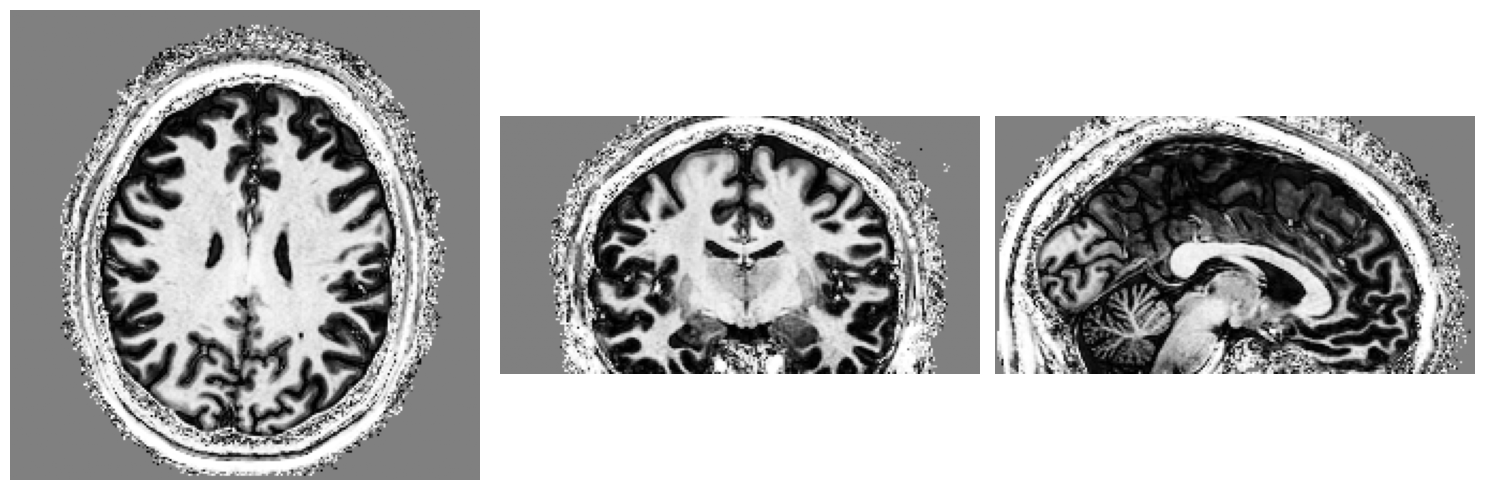

In [8]:
# MP2RAGE using Mougin's formulation
MP2RAGEn = np.real(np.multiply(np.conj(S1), S2))
MP2RAGEd = np.square(np.abs(S1)) + np.square(np.abs(S2))
MP2RAGE = np.divide(MP2RAGEn, MP2RAGEd, out=np.zeros_like(MP2RAGEn), where=(MP2RAGEd != 0))

print(f"MP2RAGE range: [{MP2RAGE.min():.4f}, {MP2RAGE.max():.4f}]")

# Save MP2RAGE
MP2RAGE_img = nib.Nifti1Image(MP2RAGE, imgm1.affine, imgm1.header)
MP2RAGE_img.set_data_dtype(np.float32)
MP2RAGE_output = os.path.join(output_dir, f"{prefix}_MP2RAGE_Mougin.nii.gz")
nib.save(MP2RAGE_img, MP2RAGE_output)
print(f"Saved: {MP2RAGE_output}")

# Visualize
print("MP2RAGE (3 orthogonal slices):")
show_slices([MP2RAGE[:, :, midslice], MP2RAGE[:, midy, :], MP2RAGE[midx, :, :]], [-0.5, 0.5])

## 6. Compute PSIR with Beta Regularization

Mougin's method includes a beta parameter to prevent division by zero:

$$\text{PSIR} = \frac{S1m - \beta}{S0 + \beta}$$

where beta is computed from the top 1% of signal values

Beta for PSIR: 422562.07
Beta for MP2RAGE: 239760955919.97
PSIRbeta range: [0.00, 276.09]
Saved: /home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_PSIRbeta_Mougin.nii.gz
PSIRbeta (3 orthogonal slices):


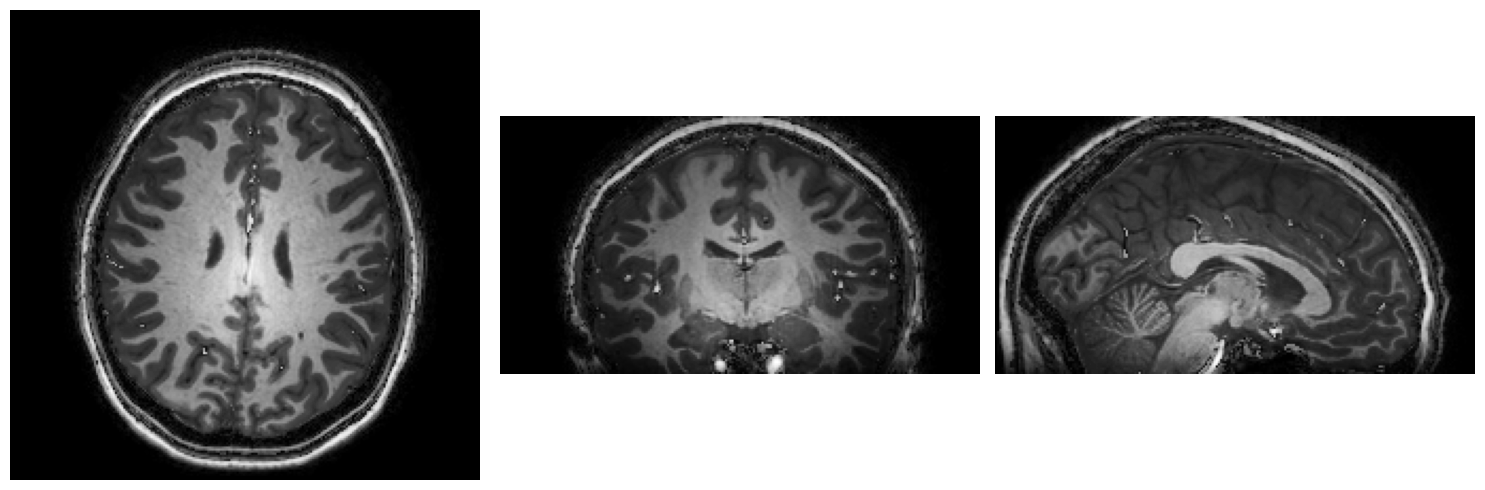

In [9]:
# Compute beta parameters (regularization to avoid division by small numbers)
aa = 1
beta = aa * np.min(maxk(np.abs(S2), round(S2.size / 100)))
beta2 = aa * np.min(maxk(np.abs(MP2RAGEd), round(MP2RAGEd.size / 100)))

print(f"Beta for PSIR: {beta:.2f}")
print(f"Beta for MP2RAGE: {beta2:.2f}")

# PSIR with beta regularization, scaled to 0-400 range
PSIRbeta = (np.divide(S1m - beta, S0 + beta, out=np.zeros_like(S1m), where=(S0 + beta != 0)) + 1) * 200

print(f"PSIRbeta range: [{PSIRbeta.min():.2f}, {PSIRbeta.max():.2f}]")

# Save PSIRbeta
PSIRbeta_img = nib.Nifti1Image(PSIRbeta, imgm1.affine, imgm1.header)
PSIRbeta_img.set_data_dtype(np.float32)
PSIRbeta_output = os.path.join(output_dir, f"{prefix}_PSIRbeta_Mougin.nii.gz")
nib.save(PSIRbeta_img, PSIRbeta_output)
print(f"Saved: {PSIRbeta_output}")

# Visualize
print("PSIRbeta (3 orthogonal slices):")
show_slices([PSIRbeta[:, :, midslice], PSIRbeta[:, midy, :], PSIRbeta[midx, :, :]])

## 7. Compute Simple PSIR (without beta)

$$\text{PSIR} = \frac{S1m}{S0}$$

PSIR range: [-0.9946, 0.9965]
Saved: /home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_PSIR_Mougin.nii.gz
PSIR (3 orthogonal slices):


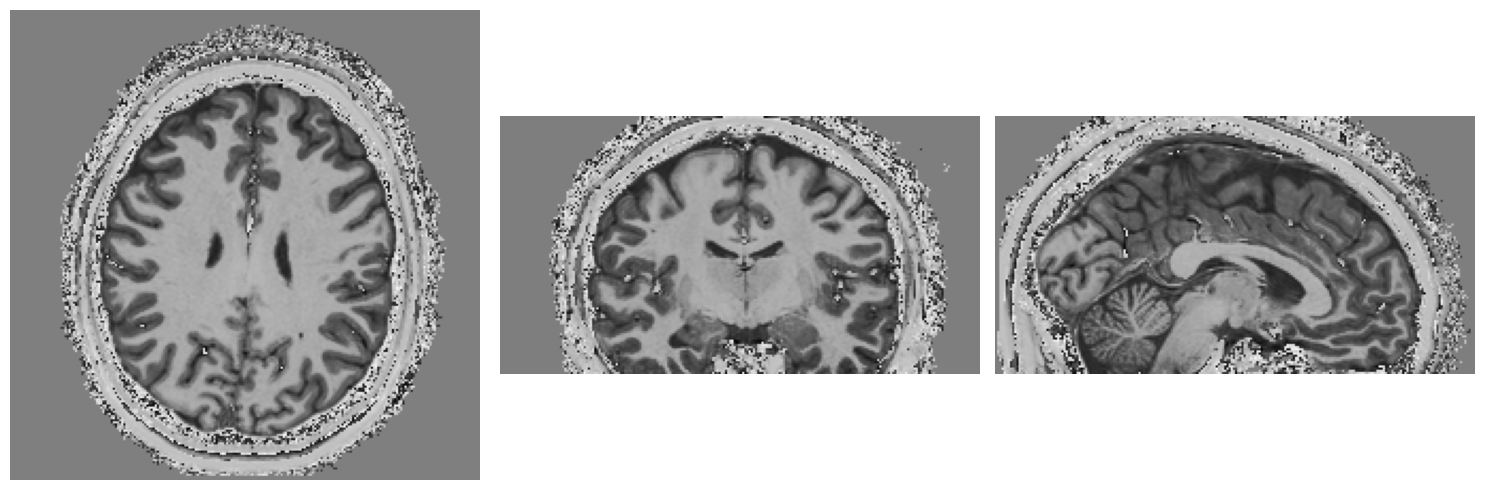

In [10]:
# Simple PSIR without beta
PSIR = np.divide(S1m, S0, out=np.zeros_like(S1m), where=(S0 != 0))

print(f"PSIR range: [{PSIR.min():.4f}, {PSIR.max():.4f}]")

# Save PSIR
PSIR_img = nib.Nifti1Image(PSIR, imgm1.affine, imgm1.header)
PSIR_img.set_data_dtype(np.float32)
PSIR_output = os.path.join(output_dir, f"{prefix}_PSIR_Mougin.nii.gz")
nib.save(PSIR_img, PSIR_output)
print(f"Saved: {PSIR_output}")

# Visualize
print("PSIR (3 orthogonal slices):")
show_slices([PSIR[:, :, midslice], PSIR[:, midy, :], PSIR[midx, :, :]])

## 8. Compute TI2_PSIR (PSIR scaled by S2)

This multiplies PSIR by the magnitude of S2 for visualization

TI2_PSIR range: [0, 3726980]
Saved: /home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix/PARREC_WIPPSIR1mm3SENSE_20141016132749_15_TI2_PSIR_Mougin.nii.gz
TI2_PSIR (3 orthogonal slices):


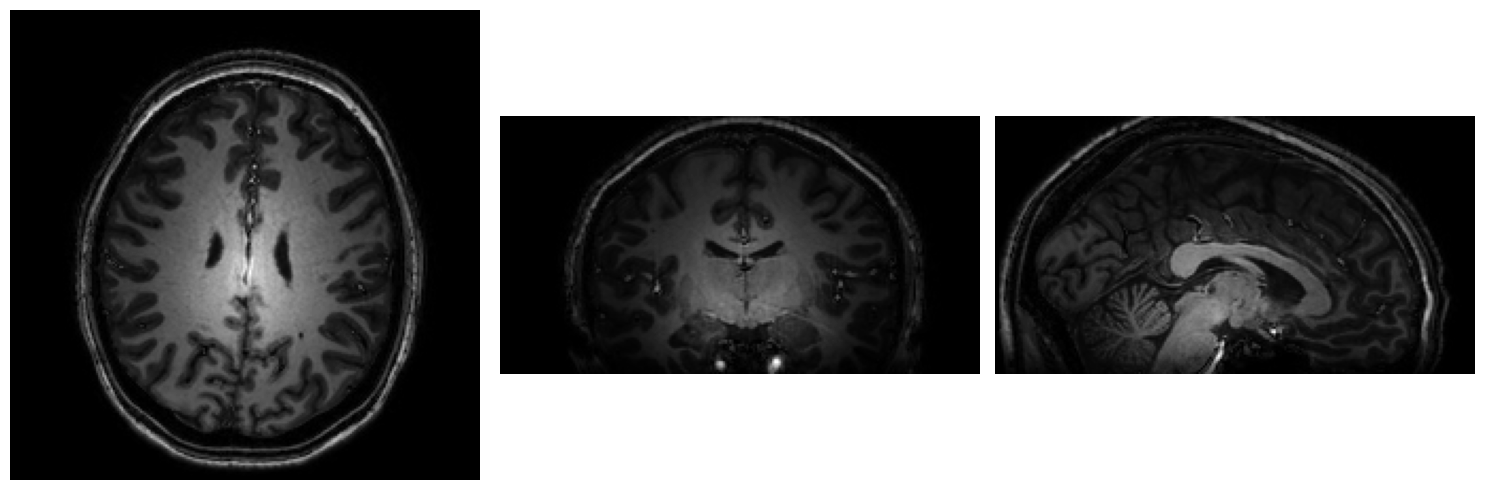

In [11]:
# TI2_PSIR: PSIR scaled by magnitude of S2
TI2_PSIR = np.multiply(PSIR + 1, np.abs(S2))

print(f"TI2_PSIR range: [{TI2_PSIR.min():.0f}, {TI2_PSIR.max():.0f}]")

# Save TI2_PSIR
TI2_PSIR_img = nib.Nifti1Image(TI2_PSIR, imgm1.affine, imgm1.header)
TI2_PSIR_img.set_data_dtype(np.float32)
TI2_PSIR_output = os.path.join(output_dir, f"{prefix}_TI2_PSIR_Mougin.nii.gz")
nib.save(TI2_PSIR_img, TI2_PSIR_output)
print(f"Saved: {TI2_PSIR_output}")

# Visualize
print("TI2_PSIR (3 orthogonal slices):")
show_slices([TI2_PSIR[:, :, midslice], TI2_PSIR[:, midy, :], TI2_PSIR[midx, :, :]])

## 9. Summary: Compare All Outputs

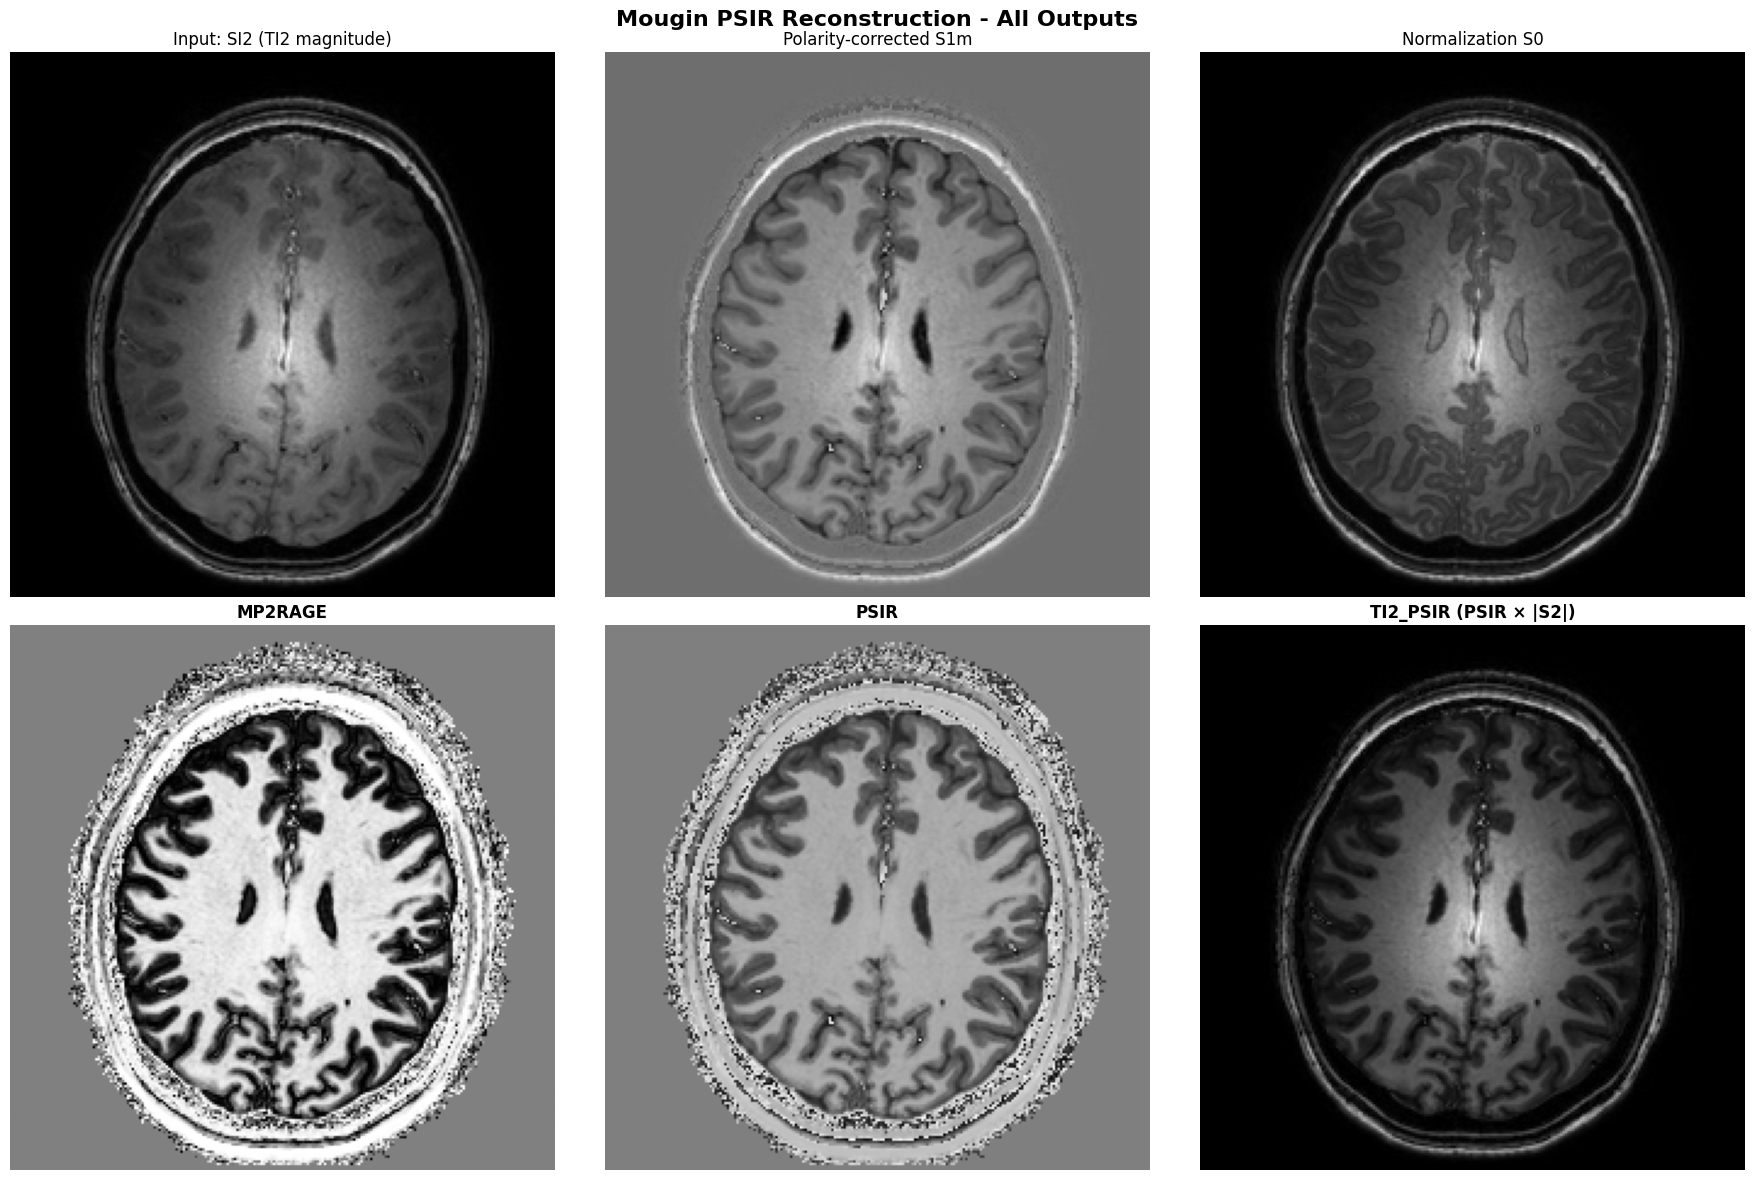


=== Summary ===
Saved outputs to: /home/mszinte/disks/meso_S/data/amblyo7T_prf/sourcedata/BM/dcm2niix
  - MP2RAGE_Mougin.nii.gz
  - PSIR_Mougin.nii.gz
  - PSIRbeta_Mougin.nii.gz
  - TI2_PSIR_Mougin.nii.gz


In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(imgm2_data[:, :, midslice].T, cmap='gray', origin='lower')
axes[0, 0].set_title('Input: SI2 (TI2 magnitude)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(S1m[:, :, midslice].T, cmap='gray', origin='lower')
axes[0, 1].set_title('Polarity-corrected S1m', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(S0[:, :, midslice].T, cmap='gray', origin='lower')
axes[0, 2].set_title('Normalization S0', fontsize=12)
axes[0, 2].axis('off')

axes[1, 0].imshow(MP2RAGE[:, :, midslice].T, cmap='gray', origin='lower', vmin=-0.5, vmax=0.5)
axes[1, 0].set_title('MP2RAGE', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(PSIR[:, :, midslice].T, cmap='gray', origin='lower')
axes[1, 1].set_title('PSIR', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(TI2_PSIR[:, :, midslice].T, cmap='gray', origin='lower')
axes[1, 2].set_title('TI2_PSIR (PSIR × |S2|)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.suptitle('Mougin PSIR Reconstruction - All Outputs', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Saved outputs to: {output_dir}")
print(f"  - MP2RAGE_Mougin.nii.gz")
print(f"  - PSIR_Mougin.nii.gz")
print(f"  - PSIRbeta_Mougin.nii.gz")
print(f"  - TI2_PSIR_Mougin.nii.gz")